In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
import time

In [2]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]

print(len(lofar))                  

11757


In [3]:
taskid = 300
batch_size = 20

if taskid*batch_size>len(lofar):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids = lofar['Source_Name'][ind_low:ind_up]

In [4]:
len(ras)

20

In [55]:
source_use = [0,1,2,3,4,5,6,7,8,9]
ras = lofar['optRA'][source_use]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][source_use][mask]

decs = lofar['optDec'][source_use]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][source_use][mask]

ids = lofar['Source_Name'][source_use]

In [5]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_HELP-PACS-maps/data/'

im100fits=imfolder + 'Lockman-SWIRE_PACS100_v0.9.fits'#PACS 100 map
im160fits=imfolder + 'Lockman-SWIRE_PACS160_v0.9.fits'#PACS 160 map

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[1].header
im100=hdulist[1].data
w_100 = wcs.WCS(hdulist[1].header)
pixsize100=3600.0*np.abs(hdulist[1].header['CDELT1']) #pixel size (in arcseconds)

nim100=hdulist[2].data
hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist[0].header
im160hdu=hdulist[1].header

im160=hdulist[1].data #convert to mJy
w_160 = wcs.WCS(hdulist[1].header)
pixsize160=3600.0*np.abs(hdulist[1].header['CDELT1']) #pixel size (in arcseconds)

nim160=hdulist[2].data
hdulist.close()

In [27]:
#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist['image'].header
im100=hdulist['image'].data
w_100 = wcs.WCS(hdulist['image'].header)
pixsize100=3600.0*np.abs(hdulist['image'].header['CDELT1']) #pixel size (in arcseconds)

nim100=hdulist['error'].data
hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist[0].header
im160hdu=hdulist['image'].header

im160=hdulist['image'].data #convert to mJy
w_160 = wcs.WCS(hdulist['image'].header)
pixsize160=3600.0*np.abs(hdulist['image'].header['CDELT1']) #pixel size (in arcseconds)

nim160=hdulist['error'].data
hdulist.close()

In [28]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat_rerun_mips.fits')

In [29]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,20,15)

In [30]:
t1 = time.time()
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=moc)
prior160.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior160.prior_bkg(0.0,5)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

time taken is: 1893.735381603241s


In [31]:
pacs100_psf=fits.open('../../../../../HELP/dmu_products/dmu18/dmu18_Lockman-SWIRE/data/dmu18_PACS_100_PSF_Lockman-SWIRE_20171214.fits')
pacs160_psf=fits.open('../../../../../HELP/dmu_products/dmu18/dmu18_Lockman-SWIRE/data/dmu18_PACS_160_PSF_Lockman-SWIRE_20171214.fits')

centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map

prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [32]:
print(pind100)

[ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.          8.33333333  8.66666667  9.          9.33333333  9.66666667
 10.        ]


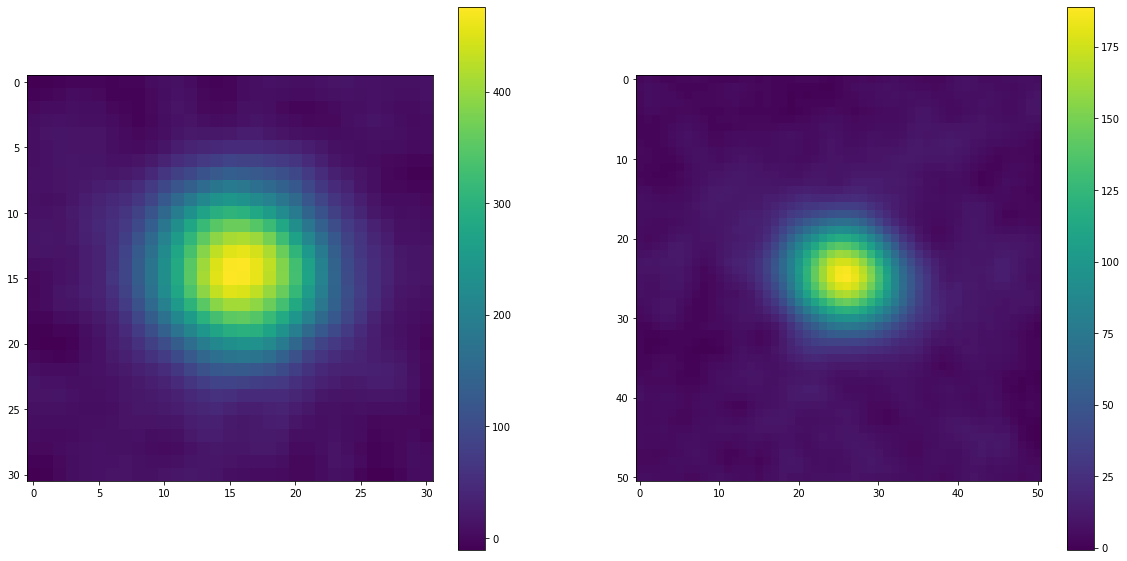

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

In [34]:
print('fitting '+ str(prior100.nsrc)+' sources \n')
print('using ' +  str(prior100.snpix)+', '+ str(prior160.snpix))



fitting 71 sources 

using 6006, 2672


In [35]:
prior100.get_pointing_matrix()
prior160.get_pointing_matrix()

In [36]:
from xidplus.stan_fit import PACS
t1 = time.time()
fit=PACS.all_bands(prior100,prior160,iter=1000)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

/XID+PACS found. Reusing
time taken is: 114.57407140731812s


In [37]:
posterior=xidplus.posterior_stan(fit,[prior100,prior160])

In [38]:
priors = [prior100,prior160]

In [ ]:
figs,fig=xidplus.plot_map(priors)

In [ ]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [39]:
import xidplus.catalogue as cat
PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])

In [40]:
PACS_cat = Table.read(PACS_cat)

In [41]:
PACS_cat[0]

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J104705.657+585138.194,161.77356931370252,58.86060949885325,3.8549473,8.562052,1.0364654,8.892623,18.857183,2.618454,5.4864974,2.1531942,7.0456734,3.126439,0.99968475,0.9996891,3367.3125,2282.7568,0.985,0.114


In [42]:
mask = [PACS_cat['help_id'][i] in ids for i in range(len(PACS_cat))]
#mask2 = ['ILTJ' in ]
PACS_cat[mask]

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ104707.71+585149.6,161.78204910223906,58.86365217839782,12.241562,18.690248,6.3226705,11.142049,19.756521,4.1822033,5.4864974,2.1531942,7.0456734,3.126439,0.9994628,1.0007172,1878.5968,2144.8171,0.973,0.019
ILTJ104707.78+580919.6,161.781725,58.155719,9.515479,18.208433,2.8392367,12.70944,26.58979,3.6929326,5.4864974,2.1531942,7.0456734,3.126439,1.0035813,0.99955827,1522.4165,1271.7112,0.999,0.721
ILTJ104707.99+595649.9,161.78319297769139,59.94714272739915,11.5152855,17.777563,5.408678,41.991814,50.774117,33.2574,5.4864974,2.1531942,7.0456734,3.126439,0.9998171,0.99894094,1993.7979,2122.827,0.996,0.021
ILTJ104708.13+595007.9,161.7838949408426,59.835541178221746,4.8006716,9.519572,1.6660708,21.004784,28.41745,13.118438,5.4864974,2.1531942,7.0456734,3.126439,0.9997767,0.9995099,2541.8577,1624.8623,0.993,0.172
ILTJ104708.18+565438.1,161.7841375891336,56.910765810130236,2.466803,5.933093,0.7087262,1.8825207,4.993256,0.531337,5.4864974,2.1531942,7.0456734,3.126439,1.0007843,0.9989188,2581.093,3563.0972,0.974,0.203
ILTJ104708.35+564332.4,161.7847807513596,56.725675889785705,3.970275,8.427762,1.163688,40.23934,49.21928,31.113638,5.4864974,2.1531942,7.0456734,3.126439,1.0001384,0.99922967,2581.6711,2393.982,0.991,0.016
ILTJ104708.40+563745.8,161.78502129417217,56.62946580354684,3.7872596,8.4064,1.0544837,35.41371,46.275322,23.72748,5.4864974,2.1531942,7.0456734,3.126439,1.0005145,1.0081164,2750.1648,833.5371,0.996,0.46
ILTJ104708.48+574427.0,161.7853219259282,57.740856790878205,3.675667,7.810403,1.112659,14.088921,22.35301,6.5317984,5.4864974,2.1531942,7.0456734,3.126439,0.9999579,1.0017371,3144.6477,1136.6487,0.961,0.549


In [43]:
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')

In [44]:
joined_pacs = join(PACS_cat,masterlist,join_type='inner',keys='help_id')

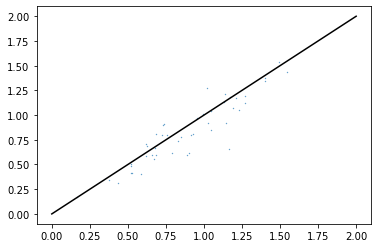

In [45]:
x = np.log10(joined_pacs['f_pacs_green']) - 3
xerr = np.log10(joined_pacs['ferr_pacs_green'])
y = np.log10(joined_pacs['F_PACS_100'])
yerr_u = np.log10(joined_pacs['FErr_PACS_100_u'])
yerr_l = np.log10(joined_pacs['FErr_PACS_100_l'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l])
plt.scatter(x,y,s=0.1)
plt.plot([0,2],[0,2],c='black')

plt.show()

In [140]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [141]:
lofar_fir

Source_id,Isl_id,RA_1,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,FLAG_OVERLAP_1,lr_fin,lr_dist_fin,lr_index_fin,fworkflow_all,FLAG_WORKFLOW,NUMBER,SNR_WIN,BACKGROUND,THRESHOLD,X_IMAGE,Y_IMAGE,ra,dec,X2_IMAGE,Y2_IMAGE,XY_IMAGE,X2_WORLD,Y2_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,FLAGS_i,CLASS_STAR,FLAGS_J,FLAGS_K,FLAGS_g,FLAGS_hscg,FLAGS_hsci,FLAGS_hscnb921,FLAGS_hscr,FLAGS_hscy,FLAGS_hscz,FLAGS_r,FLAGS_se1,FLAGS_se2,FLAGS_sw1,FLAGS_sw2,FLAGS_sw3,FLAGS_sw4,FLAGS_u,FLAGS_y,FLAGS_z,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,MAG_APER_sw4_1,MAG_APER_sw4_2,MAG_APER_sw4_3,MAG_APER_sw4_4,MAG_APER_sw4_5,MAG_APER_sw4_6,MAG_APER_sw4_7,MAG_APER_sw4_10,MAGERR_APER_sw4_1,MAGERR_APER_sw4_2,MAGERR_APER_sw4_3,MAGERR_APER_sw4_4,MAGERR_APER_sw4_5,MAGERR_APER_sw4_6,MAGERR_APER_sw4_7,MAGERR_APER_sw4_10,FLUX_APER_sw4_1,FLUX_APER_sw4_2,FLUX_APER_sw4_3,FLUX_APER_sw4_4,FLUX_APER_sw4_5,FLUX_APER_sw4_6,FLUX_APER_sw4_7,FLUX_APER_sw4_10,FLUXERR_APER_sw4_1,FLUXERR_APER_sw4_2,FLUXERR_APER_sw4_3,FLUXERR_APER_sw4_4,FLUXERR_APER_sw4_5,FLUXERR_APER_sw4_6,FLUXERR_APER_sw4_7,FLUXERR_APER_sw4_10,MAG_APER_sw1_1,MAG_APER_sw1_2,MAG_APER_sw1_3,MAG_APER_sw1_4,MAG_APER_sw1_5,MAG_APER_sw1_6,MAG_APER_sw1_7,MAG_APER_sw1_10,MAGERR_APER_sw1_1,MAGERR_APER_sw1_2,MAGERR_APER_sw1_3,MAGERR_APER_sw1_4,MAGERR_APER_sw1_5,MAGERR_APER_sw1_6,MAGERR_APER_sw1_7,MAGERR_APER_sw1_10,FLUX_APER_sw1_1,FLUX_APER_sw1_2,FLUX_APER_sw1_3,FLUX_APER_sw1_4,FLUX_APER_sw1_5,FLUX_APER_sw1_6,FLUX_APER_sw1_7,FLUX_APER_sw1_10,FLUXERR_APER_sw1_1,FLUXERR_APER_sw1_2,FLUXERR_APER_sw1_3,FLUXERR_APER_sw1_4,FLUXERR_APER_sw1_5,FLUXERR_APER_sw1_6,FLUXERR_APER_sw1_7,FLUXERR_APER_sw1_10,MAG_APER_sw3_1,MAG_APER_sw3_2,MAG_APER_sw3_3,MAG_APER_sw3_4,MAG_APER_sw3_5,MAG_APER_sw3_6,MAG_APER_sw3_7,MAG_APER_sw3_10,MAGERR_APER_sw3_1,MAGERR_APER_sw3_2,MAGERR_APER_sw3_3,MAGERR_APER_sw3_4,MAGERR_APER_sw3_5,MAGERR_APER_sw3_6,MAGERR_APER_sw3_7,MAGERR_APER_sw3_10,FLUX_APER_sw3_1,FLUX_APER_sw3_2,FLUX_APER_sw3_3,FLUX_APER_sw3_4,FLUX_APER_sw3_5,FLUX_APER_sw3_6,FLUX_APER_sw3_7,FLUX_APER_sw3_10,FLUXERR_APER_sw3_1,FLUXERR_APER_sw3_2,FLUXERR_APER_sw3_3,FLUXERR_APER_sw3_4,FLUXERR_APER_sw3_5,FLUXERR_APER_sw3_6,FLUXERR_APER_sw3_7,FLUXERR_APER_sw3_10,MAG_APER_sw2_1,MAG_APER_sw2_2,MAG_APER_sw2_3,MAG_APER_sw2_4,MAG_APER_sw2_5,MAG_APER_sw2_6,MAG_APER_sw2_7,MAG_APER_sw2_10,MAGERR_APER_sw2_1,MAGERR_APER_sw2_2,MAGERR_APER_sw2_3,MAGERR_APER_sw2_4,MAGERR_APER_sw2_5,MAGERR_APER_sw2_6,MAGERR_APER_sw2_7,MAGERR_APER_sw2_10,FLUX_APER_sw2_1,FLUX_APER_sw2_2,FLUX_APER_sw2_3,FLUX_APER_sw2_4,FLUX_APER_sw2_5,FLUX_APER_sw2_6,FLUX_APER_sw2_7,FLUX_APER_sw2_10,FLUXERR_APER_sw2_1,FLUXERR_APER_sw2_2,FLUXERR_APER_sw2_3,FLUXERR_APER_sw2_4,FLUXERR_APER_sw2_5,FLUXERR_APER_sw2_6,FLUXERR_APER_sw2_7,FLUXERR_APER_sw2_10,MAG_APER_se2_1,MAG_APER_se2_2,MAG_APER_se2_3,MAG_APER_se2_4,MAG_APER_se2_5,MAG_APER_se2_6,MAG_APER_se2_7,MAG_APER_se2_10,MAGERR_APER_se2_1,MAGERR_APER_se2_2,MAGERR_APER_se2_3,MAGERR_APER_se2_4,MAGERR_APER_se2_5,MAGERR_APER_se2_6,MAGERR_APER_se2_7,MAGERR_APER_se2_10,FLUX_APER_se2_1,FLUX_APER_se2_2,FLUX_APER_se2_3,FLUX_APER_se2_4,FLUX_APER_se2_5,FLUX_APER_se2_6,FLUX_APER_se2_7,FLUX_APER_se2_10,FLUXERR_APER_se2_1,FLUXERR_APER_se2_2,FLUXERR_APER_se2_3,FLUXERR_APER_se2_4,FLUXERR_APER_se2_5,FLUXERR_APER_se2_6,FLUXERR_APER_se2_7,FLUXERR_APER_se2_10,MAG_APER_se1_1,MAG_APER_se1_2,MAG_APER_se1_3,MAG_APER_se1_4,MAG_APER_se1_5,MAG_APER_se1_6,MAG_APER_se1_7,MAG_APER_se1_10,MAGERR_APER_se1_1,MAGERR_APER_se1_2,MAGERR_APER_se1_3,MAGERR_APER_se1_4,MAGERR_APER_se1_5,MAGERR_APER_se1_6,MAGERR_APER_se1_7,MAGERR_APER_se1_10,FLUX_APER_se1_1,FLUX_APER_se1_2,FL

In [147]:
os.path.exists('data/fir_v2/xidplus_run_3')

True

In [9]:
len(lofar)

32833